# Neural Architecture Search with PLiNIO

 

This notebook contains the following sections:

- Initial training of the "seed model"
- Neural Architecture Search with Plinio library, using Supernet-based algorithm
- Neural Architecture Search with Plinio library, using masked-based algorithm

## Simple Training

### Training scheme
The first step is a simple training of an un-optimized model, which will be our "baseline" to evaluate the effectiveness of various optimizations. We are here:

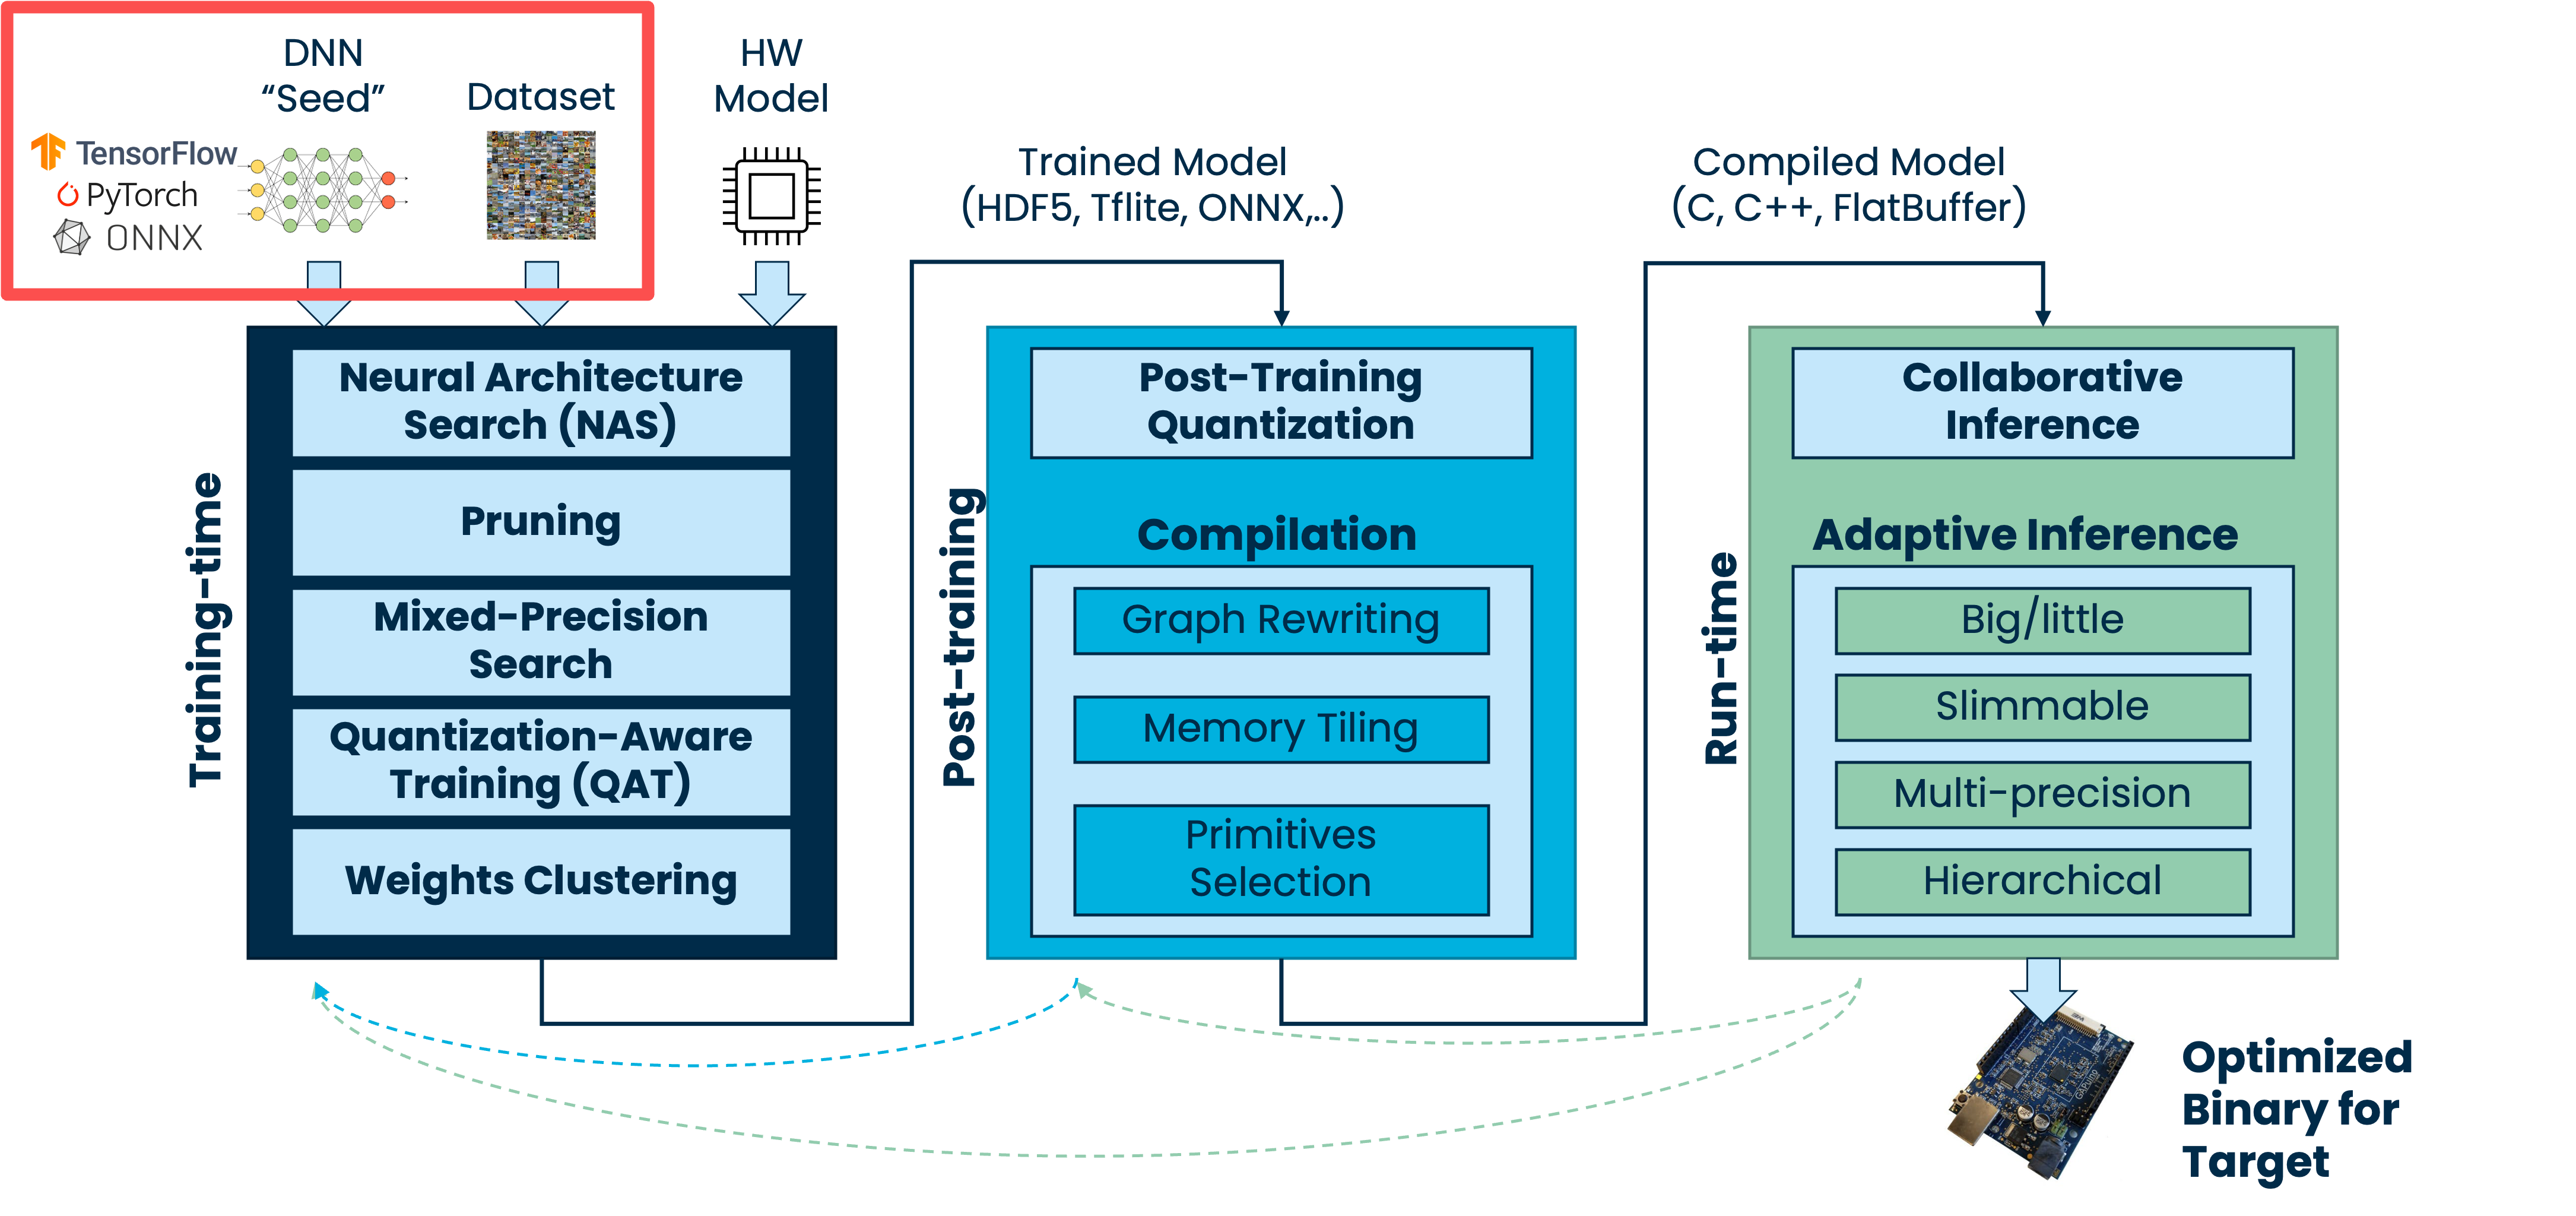

### Environment setup
Let's start with some imports. 
- we use torch library for these experiments;
- for NAS search we use plinio, which include both Supernet-based and mask-based algorithms

In [1]:
!git clone https://github.com/eml-eda/plinio.git
!git clone https://github.com/eml-eda/pytorch-benchmarks.git
!git clone https://github.com/ABurrello/material-oenne.git
!python3 -m pip install plinio/.
!python3 -m pip install pytorch-benchmarks/.
!python3 -m pip install pytorch_model_summary
!python3 -m pip install torchinfo

Cloning into 'plinio'...
remote: Enumerating objects: 2535, done.
remote: Counting objects: 100% (490/490), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 2535 (delta 316), reused 464 (delta 306), pack-reused 2045
Receiving objects: 100% (2535/2535), 6.99 MiB | 9.53 MiB/s, done.
Resolving deltas: 100% (1627/1627), done.
Cloning into 'pytorch-benchmarks'...
remote: Enumerating objects: 618, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 618 (delta 81), reused 102 (delta 37), pack-reused 459
Receiving objects: 100% (618/618), 261.90 KiB | 20.15 MiB/s, done.
Resolving deltas: 100% (301/301), done.
Cloning into 'material-oenne'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), 7.29 MiB | 8.07 MiB/s, done.
Looking in i

In [2]:
import pathlib
from typing import Dict

from pytorch_model_summary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from plinio.methods import PIT
from plinio.methods import PITSuperNet
from plinio.methods.pit.nn import PITConv2d, PITLinear
from plinio.methods.pit_supernet.nn import PITSuperNetCombiner
from plinio.methods.pit_supernet import PITSuperNetModule

import pytorch_benchmarks.image_classification as icl
from pytorch_benchmarks.utils import CheckPoint, EarlyStopping


### Download and prepare the CIFAR10 dataset

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images.

To load CIFAR10, we use the pytorch-benchmark package, where many datasets are stored and standardized

In [3]:
# Check CUDA availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# Get the Data
datasets = icl.get_data(perf_samples=False)
dataloaders = icl.build_dataloaders(datasets)
train_dl, val_dl, test_dl = dataloaders


Training on: cuda:0


100%|██████████| 170498071/170498071 [00:13<00:00, 13025235.04it/s]


Extracting /content/icl_data/cifar-10-python.tar.gz to /content/icl_data
Files already downloaded and verified


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

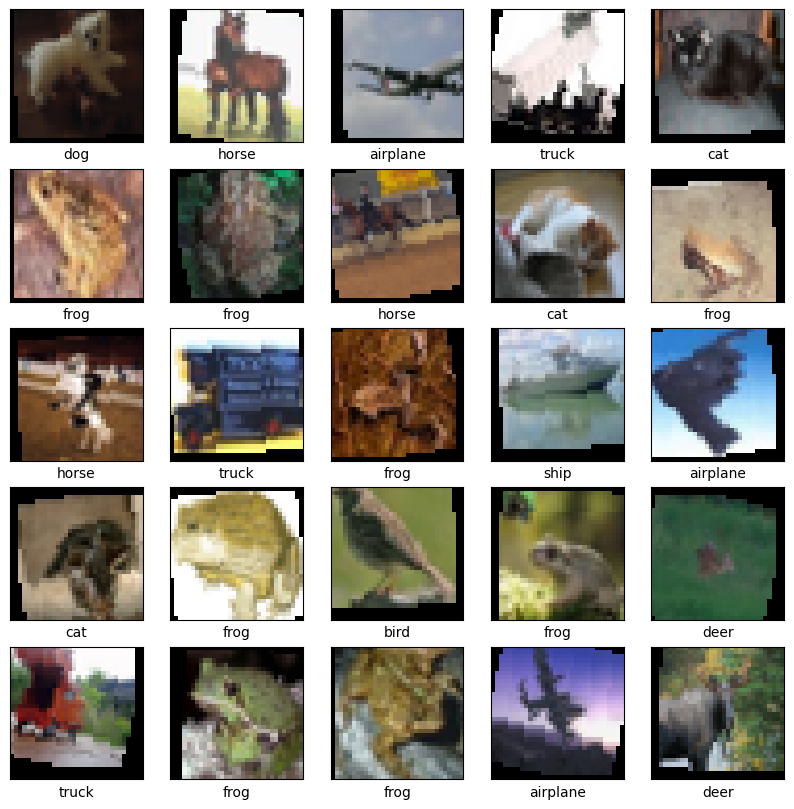

In [4]:
import matplotlib.pyplot as plt
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(datasets[0][i][0].permute(1,2,0))
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[datasets[0][i][1]])
plt.show()

### Model Creation

We will use **torch**. The network will have 5 blocks, each composed by 3 alternatives (3x3 convolution, 5x5 convolution, and 3x3 separable convolution) and an average pooling layer.

Note that each alternative is associated to a coefficient, to let the Supernet based NAS algorithm to choose between them.

#### Model creation function

For this example, we will use a simple CNN with five convolutional layers.

Let's define a convenience function to create the base block of the network, which accepts as argument a list of integers, corresponding to the number of input and output channels to use in each convolutional layer. 


In [5]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1):
        super().__init__()
        self.conv1 = PITSuperNetModule([
            nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()),
            nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 5, padding=2, stride=1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()),
            nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels, 3, groups=in_channels, padding=1, stride=1, bias=False),
                torch.nn.BatchNorm2d(in_channels),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels, out_channels, 1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()
            )], gumbel_softmax = True, hard_softmax = True)

    def forward(self, input):
        x = self.conv1(input)
        return x

class Tutorial_model(torch.nn.Module):
    def __init__(self, gumbel = False):
        super().__init__()
        ch = [16, 32, 64, 128, 256]
        self.block1 = ConvBlock(3, ch[0])
        self.maxpool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.block2 = ConvBlock(ch[0], ch[1])
        self.maxpool2 = torch.nn.MaxPool2d(2, stride = 2)
        self.block3 = ConvBlock(ch[1], ch[2])
        self.maxpool3 = torch.nn.MaxPool2d(2, stride = 2)
        self.block4 = ConvBlock(ch[2], ch[3])
        self.maxpool4 = torch.nn.MaxPool2d(2, stride = 2)
        self.block5 = ConvBlock(ch[3], ch[4])
        self.maxpool5 = torch.nn.MaxPool2d(2, stride = 2)
        self.out = nn.Linear(256, 10)

    def forward(self, input):
        # Input layer
        x = self.block1(input)  # [16, 16, 16]
        x = self.maxpool1(x)      # [8, 8, 32]
        x = self.block2(x)      # [8, 8, 32]
        x = self.maxpool2(x)      # [8, 8, 32]
        x = self.block3(x)      # [4, 4, 64]
        x = self.maxpool3(x)      # [8, 8, 32]
        x = self.block4(x)      # [2, 2, 128]
        x = self.maxpool4(x)      # [8, 8, 32]
        x = self.block5(x)      # [1, 1, 256]
        x = self.maxpool5(x)      # [8, 8, 32]
        x = torch.flatten(x, 1)
        x = self.out(x)         # [10]

        return x
        
model = Tutorial_model()
model = model.to(device)
input_example = torch.unsqueeze(datasets[0][0][0], 0).to(device)
input_shape = datasets[0][0][0].numpy().shape
print(summary(model, input_example, show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       ConvBlock-1     [1, 16, 32, 32]           1,828           1,825
       MaxPool2d-2     [1, 16, 16, 16]               0               0
       ConvBlock-3     [1, 32, 16, 16]          18,323          18,320
       MaxPool2d-4       [1, 32, 8, 8]               0               0
       ConvBlock-5       [1, 64, 8, 8]          72,483          72,480
       MaxPool2d-6       [1, 64, 4, 4]               0               0
       ConvBlock-7      [1, 128, 4, 4]         288,323         288,320
       MaxPool2d-8      [1, 128, 2, 2]               0               0
       ConvBlock-9      [1, 256, 2, 2]       1,150,083       1,150,080
      MaxPool2d-10      [1, 256, 1, 1]               0               0
         Linear-11             [1, 10]           2,570           2,570
Total params: 1,533,610
Trainable params: 1,533,595
Non-trainable params: 15

### Compile and Train the Model

As you can see, the "seed model" has 1.533M parameter. Now let's train it  to evaluate its accuracy.

In [6]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"
N_EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
for epoch in range(N_EPOCHS):
    metrics = icl.train_one_epoch(epoch, model, criterion, optimizer, train_dl, val_dl, device)
    scheduler.step()

Epoch 10: 100%|██████████| 1250/1250 [00:37<00:00, 33.01batch/s, loss=1.4, acc=49.1, val_loss=1.36, val_acc=50.2]


As you may imagine, 10 epochs are not enough for convergence, therefore we load a pre-trained model.

In [7]:
def save(model, path):
    torch.save({
              'model_state_dict': model.state_dict()
              }, path)
        
def load(model, path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    # checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# save(model, 'supernet_pretrained.pt')
model=load(model, 'material-oenne/models/supernet_pretrained.pt')

### Evaluate the Model

Let's look at the accuracy of the network before applying the NAS.

In [8]:
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')


Test Loss: 0.6639887094497681, Test Acc: 77.06999969482422


## Neural Architecture Search with Supernet

Let's now move to the first optimization, Neural Architecture Search (NAS). We are here:

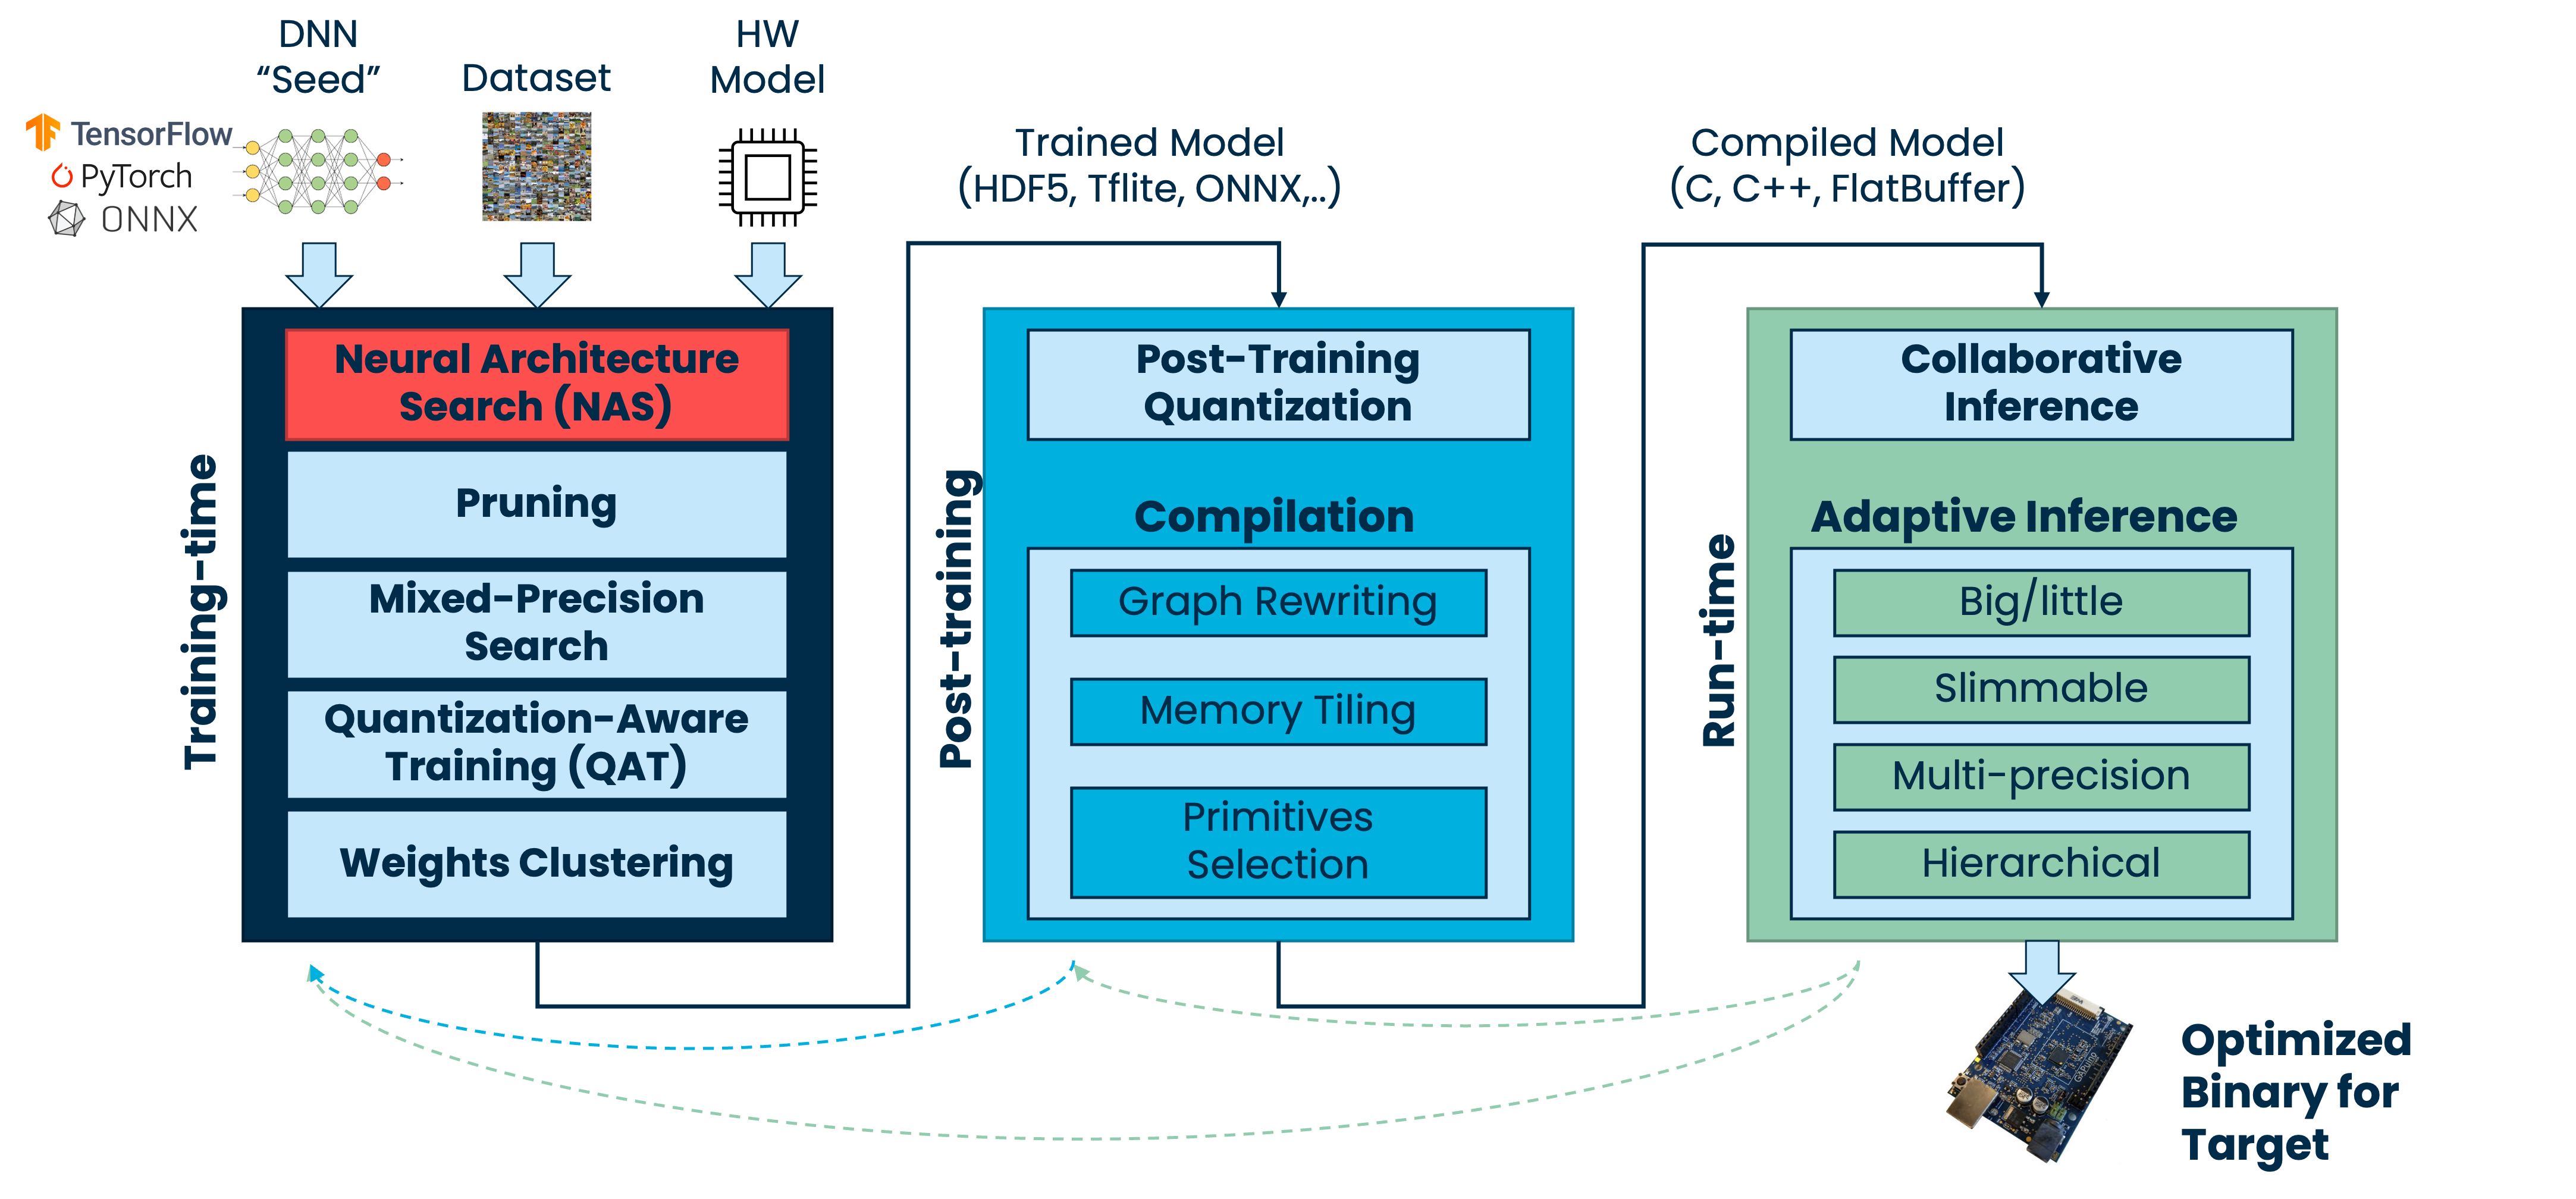

We will use a sequence of 2 lightweight NAS tool inside [PliNIO library](https://github.com/eml-eda/plinio) based on masking to optimize the architecture of the network.

**Supernet** is a typical NAS based on the optimization of _multiple layer choices_. For each hidden layer of the network, multiple alternatives are chosen

**PIT (Pruning in Time)** is a sort of hybrid between mask-based DNAS and node pruning. In particular, it only focuses on optimizing the **number of features/channels** in Convolutional layers, and optionally FC layers, if you rewrite them as convolutions (see above). While focusing only on the number of features surely limits the optimization scope of the tool, at the same time it makes it extremely efficient and lightweight, which is especially good for live demos! 😀


In class, you have seen that this can be achieved through so-called mask layers:

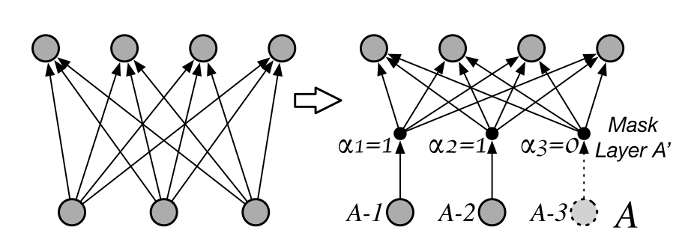

Where the binary masks alpha are trained together with the layer weights, using shadow copies in floating point and the straight through estimator (STE) technique. A regularizer on the shadow copies forces them to small values, thus allowing the elimination of unimportant features.


### Train one-epoch definition

In this example, we will use the`model_size_regularizer`, which models the total number of **parameters** in the layer as a function of alfa parameters, and can be used to optimize the _total memory occupation_ of the model.

A couple of things to notice:

- to add the model_regularizers to the training loop, we just need 3 lines 
            loss_reg = cd_size * model.get_size()
            loss_ops = cd_ops * model.get_macs()
            loss = loss + loss_ops + loss_reg
  The first line defines the `model_size_regularizer`.
  The second line defines the `model_ops_regularizer`. 
  The third line adds to the task loss the two previous ones. 

- The regularizer strength is set to 5e-4. This is the parameter that determines how agressive PLinio is in choosing a smaller network. Higher values produce an overall smaller network at the cost of a possible accuracy degradation.

In [9]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_benchmarks.utils import AverageMeter, accuracy

def _run_model(model, image, target, criterion, device):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def train_one_epoch(
        epoch: int,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        train: DataLoader,
        val: DataLoader,
        device: torch.device,
        cd_size,
        cd_ops) -> Dict[str, float]:
    model.train()
    avgacc = AverageMeter('6.2f')
    avgloss = AverageMeter('2.5f')
    avglosstask = AverageMeter('2.5f')
    avglossreg = AverageMeter('2.5f')
    step = 0
    with tqdm(total=len(train), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for image, target in train:
            step += 1
            tepoch.update(1)
            image, target = image.to(device), target.to(device)
            output, loss_task = _run_model(model, image, target, criterion, device)
            loss_reg = cd_size * model.get_size()
            loss_ops = cd_ops * model.get_macs()
            loss = loss_task + loss_ops + loss_reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc_val = accuracy(output, target, topk=(1,))
            avgacc.update(acc_val[0], image.size(0))
            avgloss.update(loss, image.size(0))
            avglosstask.update(loss_task, image.size(0))
            avglossreg.update(loss_reg, image.size(0))
            if step % 100 == 99:
                tepoch.set_postfix({'loss': avgloss,
                                    'loss_task': avglosstask,
                                    'loss_reg': avglossreg,
                                    'acc': avgacc})
        val_metrics = icl.evaluate(model, criterion, val, device)
        val_metrics = {'val_' + k: v for k, v in val_metrics.items()}
        final_metrics = {
            'loss': avgloss.get(),
            'loss_task': avglosstask,
            'loss_reg': avglossreg,
            'acc': avgacc.get(),
        }
        final_metrics.update(val_metrics)
        tepoch.set_postfix(final_metrics)
        tepoch.close()
    return final_metrics

### Definition of the SuperNet through PLiNIO
Starting from the seed network, the PITSuperNet module add a coefficient _alfa_ to each alternative of the block. A softmax between them allows to choose of a single alternative.

In [10]:
import copy
model_to_nas = copy.deepcopy(model)
nas_model_supernet = PITSuperNet(model_to_nas, input_shape=input_shape, autoconvert_layers = False)
nas_model_supernet = nas_model_supernet.to(device)

N_EPOCHS = 10
criterion = nn.CrossEntropyLoss()
param_dicts = [
    {'params': nas_model_supernet.nas_parameters(), 'weight_decay': 0},
    {'params': nas_model_supernet.net_parameters()}]
optimizer = torch.optim.Adam(param_dicts, lr=0.001, weight_decay=1e-4)
scheduler = icl.get_default_scheduler(optimizer)

cd_size = 5e-6
cd_ops = 0
print("Initial model size:", nas_model_supernet.get_size())
print("Initial model MACs:", nas_model_supernet.get_macs())
for module in nas_model_supernet.modules(): 
  if isinstance(module, PITSuperNetCombiner):
    print(nn.functional.softmax(module.alpha, dim=0))


Initial model size: tensor(393104., device='cuda:0')
Initial model MACs: tensor(5161952., device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


### Training of the Supernet

In [11]:
for epoch in range(N_EPOCHS):
    metrics = train_one_epoch(epoch, nas_model_supernet, criterion, optimizer, train_dl, val_dl, device, cd_size, cd_ops)
    scheduler.step()
    print("model size:", nas_model_supernet.get_size())
    print("model MACs:", nas_model_supernet.get_macs())
    for module in nas_model_supernet.modules(): 
      if isinstance(module, PITSuperNetCombiner):
        print(nn.functional.softmax(module.alpha, dim=0))

Epoch 1: 100%|██████████| 1250/1250 [00:47<00:00, 26.12batch/s, loss=2.83, loss_task=1.03692, loss_reg=1.79659, acc=63.9, val_loss=0.972, val_acc=65.1]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.3726, 0.3657, 0.2618], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3967, 0.2604, 0.3429], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3342, 0.1351, 0.5307], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2476, 0.0926, 0.6599], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2365, 0.0910, 0.6725], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Epoch 2: 100%|██████████| 1250/1250 [00:48<00:00, 25.74batch/s, loss=1.78, loss_task=1.00178, loss_reg=0.77911, acc=64.7, val_loss=0.912, val_acc=67.9]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.4160, 0.3633, 0.2208], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4487, 0.2120, 0.3393], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2670, 0.0591, 0.6739], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0864, 0.0271, 0.8866], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0673, 0.0239, 0.9088], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Epoch 3: 100%|██████████| 1250/1250 [00:49<00:00, 25.09batch/s, loss=1.39, loss_task=0.96491, loss_reg=0.42975, acc=65.9, val_loss=0.97, val_acc=65.6]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.4478, 0.3752, 0.1771], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4923, 0.1740, 0.3337], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1935, 0.0291, 0.7775], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0294, 0.0095, 0.9611], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0197, 0.0081, 0.9723], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Epoch 4: 100%|██████████| 1250/1250 [00:49<00:00, 25.08batch/s, loss=1.27, loss_task=0.94056, loss_reg=0.32709, acc=67, val_loss=0.892, val_acc=68.1]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.4776, 0.3904, 0.1320], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5187, 0.1470, 0.3343], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1416, 0.0157, 0.8428], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0113, 0.0040, 0.9848], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0080, 0.0035, 0.9885], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Epoch 5: 100%|██████████| 1250/1250 [00:49<00:00, 25.41batch/s, loss=1.21, loss_task=0.91656, loss_reg=0.29079, acc=67.6, val_loss=0.893, val_acc=68.3]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.4825, 0.3932, 0.1243], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5255, 0.1206, 0.3539], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1030, 0.0091, 0.8879], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0054, 0.0019, 0.9927], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0037, 0.0019, 0.9944], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Epoch 6: 100%|██████████| 1250/1250 [00:50<00:00, 24.89batch/s, loss=1.2, loss_task=0.91139, loss_reg=0.28567, acc=67.8, val_loss=0.846, val_acc=69.6]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.4982, 0.4004, 0.1014], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5656, 0.0974, 0.3370], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0724, 0.0052, 0.9224], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0027, 0.0011, 0.9962], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1.8760e-03, 9.8062e-04, 9.9714e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Epoch 7: 100%|██████████| 1250/1250 [00:49<00:00, 25.14batch/s, loss=1.15, loss_task=0.88605, loss_reg=0.26578, acc=68.7, val_loss=0.915, val_acc=67.7]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.5247, 0.3903, 0.0850], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5901, 0.0836, 0.3263], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0530, 0.0034, 0.9436], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1.6260e-03, 6.8595e-04, 9.9769e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1.1885e-03, 6.2712e-04, 9.9818e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Epoch 8: 100%|██████████| 1250/1250 [00:54<00:00, 22.86batch/s, loss=1.14, loss_task=0.87117, loss_reg=0.26549, acc=69.2, val_loss=0.863, val_acc=68.9]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.5451, 0.3831, 0.0718], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5916, 0.0713, 0.3371], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0375, 0.0023, 0.9603], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1.0070e-03, 4.3209e-04, 9.9856e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([6.4896e-04, 3.5524e-04, 9.9900e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Epoch 9: 100%|██████████| 1250/1250 [00:50<00:00, 24.62batch/s, loss=1.13, loss_task=0.85927, loss_reg=0.26643, acc=69.8, val_loss=0.852, val_acc=69.7]


model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.5721, 0.3660, 0.0620], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6103, 0.0568, 0.3330], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0266, 0.0016, 0.9719], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([6.5617e-04, 2.9167e-04, 9.9905e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([4.4135e-04, 2.4706e-04, 9.9931e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Epoch 10: 100%|██████████| 1250/1250 [00:50<00:00, 24.79batch/s, loss=1.11, loss_task=0.85203, loss_reg=0.25906, acc=70.1, val_loss=0.825, val_acc=70.6]

model size: tensor(51952., device='cuda:0')
model MACs: tensor(2056096., device='cuda:0')
tensor([0.5969, 0.3537, 0.0493], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6258, 0.0464, 0.3279], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0196, 0.0012, 0.9792], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([4.2869e-04, 1.9991e-04, 9.9937e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([3.2030e-04, 1.8539e-04, 9.9949e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


Now let's check the accuracy and the model size after the search

In [12]:
# Convert Supernet model into pytorch model
exported_model = nas_model_supernet.arch_export()
exported_model = exported_model.to(device)
print(summary(exported_model, input_example, show_input=False, show_hierarchical=True))
test_metrics = icl.evaluate(exported_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       MaxPool2d-1     [1, 16, 16, 16]               0               0
       MaxPool2d-2       [1, 32, 8, 8]               0               0
       MaxPool2d-3       [1, 64, 4, 4]               0               0
       MaxPool2d-4      [1, 128, 2, 2]               0               0
       MaxPool2d-5      [1, 256, 1, 1]               0               0
          Linear-6             [1, 10]           2,570           2,570
Total params: 2,570
Trainable params: 2,570
Non-trainable params: 0
-----------------------------------------------------------------------


================================================== Hierarchical Summary ==================================================

Tutorial_model(
  (block1): Module(
    (conv1): Module(
      (sn_input_layers): Module(
        (0): Module(
          (0): Conv2d(3, 16, kernel_size=(3, 3), strid

### Application of PIT after Supernet
After the application of SuperNet for each layers' block we have selected a single layer. SuperNet allows to choose the best layer for the trade-off accuracy vs. size, based on the value of the cd_size specified.

The second step, is the application of PIT. PIT could be applied also individually, on a predefined seed neural network. In this case, we will apply it on top of the Supernet searched network, to improve the accuracy.

As can be noticed by the fragment of code 

      nas_model.train_features = True
      nas_model.train_rf = False
      nas_model.train_dilation = False

we will search with PIT only the number of channels of each layer.

In [13]:
model_to_nas = copy.deepcopy(exported_model)
nas_model_pit = PIT(model_to_nas, input_shape=input_shape)
nas_model_pit = nas_model_pit.to(device)
nas_model_pit.train_features = True
nas_model_pit.train_rf = False
nas_model_pit.train_dilation = False

N_EPOCHS = 20
criterion = nn.CrossEntropyLoss()
param_dicts = [
    {'params': nas_model_pit.nas_parameters(), 'weight_decay': 0},
    {'params': nas_model_pit.net_parameters()}]
optimizer = torch.optim.Adam(param_dicts, lr=0.001, weight_decay=1e-4)
scheduler = icl.get_default_scheduler(optimizer)

cd_size = 1e-6
cd_ops = 0

for epoch in range(N_EPOCHS):
    metrics = train_one_epoch(epoch, nas_model_pit, criterion, optimizer, train_dl, val_dl, device, cd_size, cd_ops)
    scheduler.step()
    print("model size:", nas_model_pit.get_size_binarized())
    print("model MACs:", nas_model_pit.get_macs_binarized())

Epoch 1: 100%|██████████| 1250/1250 [00:38<00:00, 32.55batch/s, loss=0.917, loss_task=0.86489, loss_reg=0.05182, acc=69.4, val_loss=0.911, val_acc=68.4]


model size: tensor(52624., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2050048., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2: 100%|██████████| 1250/1250 [00:38<00:00, 32.66batch/s, loss=0.884, loss_task=0.83415, loss_reg=0.05009, acc=70.6, val_loss=0.86, val_acc=69.3]


model size: tensor(52486., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2049526., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3: 100%|██████████| 1250/1250 [00:38<00:00, 32.79batch/s, loss=0.873, loss_task=0.82518, loss_reg=0.04809, acc=71, val_loss=0.909, val_acc=68]


model size: tensor(52348., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2049004., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4: 100%|██████████| 1250/1250 [00:38<00:00, 32.68batch/s, loss=0.865, loss_task=0.81908, loss_reg=0.04610, acc=71.2, val_loss=0.87, val_acc=69.8]


model size: tensor(51747., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2045892., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5: 100%|██████████| 1250/1250 [00:38<00:00, 32.53batch/s, loss=0.851, loss_task=0.80716, loss_reg=0.04416, acc=71.5, val_loss=0.821, val_acc=71.4]


model size: tensor(51747., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2045892., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6: 100%|██████████| 1250/1250 [00:38<00:00, 32.88batch/s, loss=0.839, loss_task=0.79691, loss_reg=0.04232, acc=72, val_loss=0.854, val_acc=70]


model size: tensor(51199., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2043820., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7: 100%|██████████| 1250/1250 [00:37<00:00, 33.75batch/s, loss=0.828, loss_task=0.78699, loss_reg=0.04054, acc=72.2, val_loss=0.802, val_acc=71.9]


model size: tensor(50925., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2042784., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8: 100%|██████████| 1250/1250 [00:37<00:00, 33.65batch/s, loss=0.817, loss_task=0.77773, loss_reg=0.03899, acc=72.7, val_loss=0.797, val_acc=72.4]


model size: tensor(50788., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2042266., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9: 100%|██████████| 1250/1250 [00:38<00:00, 32.78batch/s, loss=0.81, loss_task=0.77229, loss_reg=0.03754, acc=72.9, val_loss=0.817, val_acc=71.4]


model size: tensor(50651., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2041748., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10: 100%|██████████| 1250/1250 [00:37<00:00, 32.90batch/s, loss=0.803, loss_task=0.76639, loss_reg=0.03620, acc=72.9, val_loss=0.833, val_acc=70.8]


model size: tensor(49926., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2038170., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11: 100%|██████████| 1250/1250 [00:38<00:00, 32.82batch/s, loss=0.799, loss_task=0.76363, loss_reg=0.03488, acc=72.8, val_loss=0.845, val_acc=70.5]


model size: tensor(48838., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(2034058., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12: 100%|██████████| 1250/1250 [00:38<00:00, 32.55batch/s, loss=0.796, loss_task=0.76192, loss_reg=0.03372, acc=73.1, val_loss=0.795, val_acc=71.8]


model size: tensor(46965., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1985430., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13: 100%|██████████| 1250/1250 [00:38<00:00, 32.83batch/s, loss=0.785, loss_task=0.75273, loss_reg=0.03262, acc=73.4, val_loss=0.84, val_acc=70.8]


model size: tensor(47100., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1985940., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14: 100%|██████████| 1250/1250 [00:38<00:00, 32.50batch/s, loss=0.782, loss_task=0.75014, loss_reg=0.03156, acc=73.5, val_loss=0.777, val_acc=72.6]


model size: tensor(45938., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1940834., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15: 100%|██████████| 1250/1250 [00:38<00:00, 32.60batch/s, loss=0.781, loss_task=0.75062, loss_reg=0.03055, acc=73.5, val_loss=0.828, val_acc=70.8]


model size: tensor(44993., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1937264., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16: 100%|██████████| 1250/1250 [00:37<00:00, 32.98batch/s, loss=0.769, loss_task=0.73961, loss_reg=0.02964, acc=73.7, val_loss=0.825, val_acc=70.8]


model size: tensor(44858., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1936754., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17: 100%|██████████| 1250/1250 [00:37<00:00, 33.54batch/s, loss=0.76, loss_task=0.73141, loss_reg=0.02883, acc=74.1, val_loss=0.795, val_acc=72]


model size: tensor(44048., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1933694., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18: 100%|██████████| 1250/1250 [00:38<00:00, 32.37batch/s, loss=0.762, loss_task=0.73349, loss_reg=0.02806, acc=73.8, val_loss=0.79, val_acc=72.1]


model size: tensor(42432., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1925934., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19: 100%|██████████| 1250/1250 [00:38<00:00, 32.77batch/s, loss=0.76, loss_task=0.73235, loss_reg=0.02738, acc=74.1, val_loss=0.768, val_acc=73]


model size: tensor(41900., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1923098., device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20: 100%|██████████| 1250/1250 [00:38<00:00, 32.71batch/s, loss=0.753, loss_task=0.72662, loss_reg=0.02667, acc=74.1, val_loss=0.796, val_acc=72.3]

model size: tensor(41419., device='cuda:0', grad_fn=<AddBackward0>)
model MACs: tensor(1880566., device='cuda:0', grad_fn=<AddBackward0>)


In [14]:
# Convert Supernet model into pytorch model
final_model = nas_model_pit.arch_export()
final_model = final_model.to(device)
print(summary(final_model, input_example, show_input=False, show_hierarchical=True))
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       MaxPool2d-1     [1, 16, 16, 16]               0               0
       MaxPool2d-2       [1, 29, 8, 8]               0               0
       MaxPool2d-3       [1, 64, 4, 4]               0               0
       MaxPool2d-4      [1, 122, 2, 2]               0               0
       MaxPool2d-5      [1, 191, 1, 1]               0               0
          Linear-6             [1, 10]           1,920           1,920
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
-----------------------------------------------------------------------


================================================= Hierarchical Summary =================================================

GraphModule(
  (block1): Module(
    (conv1): Module(
      (sn_input_layers): Module(
        (0): Module(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1,

The last step is the finetuning. The architecture is fixed and we only train the weights to improve accuracy.

In [15]:
N_EPOCHS = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_model.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
for epoch in range(N_EPOCHS):
    metrics = icl.train_one_epoch(epoch, final_model, criterion, optimizer, train_dl, val_dl, device)
    scheduler.step()

Epoch 40: 100%|██████████| 1250/1250 [00:28<00:00, 43.46batch/s, loss=0.582, acc=79.4, val_loss=0.649, val_acc=77.1]


### Final Report
With this final report, we analyze the topology, the size, and the accuracy of the solution at each different step of the search. Noteworthy, by changing the values of the cd_size at the different stages, we push to PLiNIO to choose more or less lightweight layers and to increase or decrease the ratio of the pruning done with PIT.

In [16]:
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Initial Model. Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print(summary(model, input_example, show_input=False, show_hierarchical=True))
test_metrics = icl.evaluate(exported_model, criterion, test_dl, device)
print(f'Supernet Model. Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print(summary(exported_model, input_example, show_input=False, show_hierarchical=True))
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Final Model. Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')
print(summary(final_model, input_example, show_input=False, show_hierarchical=True))

Initial Model. Test Loss: 0.6639887094497681, Test Acc: 77.06999969482422
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
       ConvBlock-1     [1, 16, 32, 32]           1,828           1,825
       MaxPool2d-2     [1, 16, 16, 16]               0               0
       ConvBlock-3     [1, 32, 16, 16]          18,323          18,320
       MaxPool2d-4       [1, 32, 8, 8]               0               0
       ConvBlock-5       [1, 64, 8, 8]          72,483          72,480
       MaxPool2d-6       [1, 64, 4, 4]               0               0
       ConvBlock-7      [1, 128, 4, 4]         288,323         288,320
       MaxPool2d-8      [1, 128, 2, 2]               0               0
       ConvBlock-9      [1, 256, 2, 2]       1,150,083       1,150,080
      MaxPool2d-10      [1, 256, 1, 1]               0               0
         Linear-11             [1, 10]           2,570           2,570
To

### Save the final model

In [17]:
torch.save(final_model, "PIT_Supernet.pt")